In [96]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, QED
from IPython.display import SVG, display
import deepchem as dc

In [97]:
def calculate_molecular_properties(mol):

    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    rotatable_bonds = Descriptors.NumRotatableBonds(mol)
    psa = Descriptors.TPSA(mol)
    mol_refractivity = Descriptors.MolMR(mol)
    atoms = mol.GetNumAtoms()
    qed = QED.qed(mol)

    return {
        'MW': mw,
        'LogP': logp,
        'HBD': hbd,
        'HBA': hba,
        'RotBonds': rotatable_bonds,
        'PSA': psa,
        'MR': mol_refractivity,
        'Atoms': atoms,
        'QED': qed
    }
    
    

In [98]:
# Lipinski Rule of 5

def check_lipinski_ro5(properties):
    rules = {
        'MW <= 500': properties['MW'] <= 500,
        'LogP <= 5': properties['LogP'] <= 5,
        'HBD <= 5': properties['HBD'] <= 5,
        'HBA <= 10': properties['HBA'] <= 10
    }

    overall_pass = all(rules.values())

    return rules, overall_pass

In [99]:
# Rule of 3

def check_ro3(properties):
    rules = {
        'MW <= 300': properties['MW'] <= 300,
        'LogP <= 3': properties['LogP'] <= 3,
        'HBD <= 3': properties['HBD'] <= 3,
        'HBA <= 3': properties['HBA'] <= 3,
        'RotBonds <= 3': properties['RotBonds'] <= 3
    }

    overall_pass = all(rules.values())

    return rules, overall_pass

In [100]:
# Veber Filter

def check_veber(properties):
    rules = {
        'RotBonds <= 10': properties['RotBonds'] <= 10,
        'PSA <= 140': properties['PSA'] <= 140,

    }

    overall_pass = all(rules.values())

    return rules, overall_pass

In [101]:
# Ghose Filter

def check_ghose(properties):
    rules = {
        'MW: 160 to 480': properties['MW'] >= 160 and properties['MW'] <= 480,
        'LogP: 0.4 to 5.6': properties['LogP'] >= 0.4 and properties['LogP'] <= 5.6,
        'MR: 40 to 130': properties['MR'] >= 40 and properties['MR'] <= 130,
        'Atoms: 20 to 70': properties['Atoms'] >= 20 and properties['Atoms'] <= 70
    }

    overall_pass = all(rules.values())

    return rules, overall_pass

In [102]:
def visualize_molecule(mol, molecule_name="Molecule"):
    
    drawer = Draw.rdMolDraw2D.MolDraw2DSVG(400, 400)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg))

In [103]:
def check_druglikeness(smiles, molecule_name='Unknown'):
   
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Error: invalid SMILES '{smiles}'")
        return None
    
    properties = calculate_molecular_properties(mol)
    
    ro5_rules, ro5_pass = check_lipinski_ro5(properties)
    ro3_rules, ro3_pass = check_ro3(properties)
    veber_rules, veber_pass = check_veber(properties)
    ghose_rules, ghose_pass = check_ghose(properties)
    
    
    print(f"{molecule_name}")
    print(f"SMILES: {smiles}\n")
    
    
    print("Molecular Properties:")
    print(f"  MW: {properties['MW']:.2f} Da")
    print(f"  LogP: {properties['LogP']:.2f}")
    print(f"  HBD: {properties['HBD']}")
    print(f"  HBA: {properties['HBA']}")
    print(f"  Rotatable Bonds: {properties['RotBonds']}")
    print(f"  PSA: {properties['PSA']:.2f} Ų")
    print(f"  Molar Refractivity: {properties['MR']:.2f}")
    print(f"  Atoms: {properties['Atoms']}")
    print(f"  QED Score: {properties['QED']:.3f}\n")
    
    # Rule of 5
    print("Lipinski's Rule of 5:")
    for rule, passed in ro5_rules.items():
        print(f"  {rule}: {'Pass' if passed else 'Fail'}")
    print(f"  Overall: {'Pass' if ro5_pass else 'Fail'}\n")
    
    # Rule of 3
    print("Rule of 3:")
    for rule, passed in ro3_rules.items():
        print(f"  {rule}: {'Pass' if passed else 'Fail'}")
    print(f"  Overall: {'Pass' if ro3_pass else 'Fail'}\n")
    
    # Veber
    print("Veber Filter:")
    for rule, passed in veber_rules.items():
        print(f"  {rule}: {'Pass' if passed else 'Fail'}")
    print(f"  Overall: {'Pass' if veber_pass else 'Fail'}\n")
    
    # Ghose
    print("Ghose Filter:")
    for rule, passed in ghose_rules.items():
        print(f"  {rule}: {'Pass' if passed else 'Fail'}")
    print(f"  Overall: {'Pass' if ghose_pass else 'Fail'}\n")

    # Overall Verdict
    if ro5_pass and veber_pass:
        verdict = 'Likely orally bioavailable drug candidate'
    elif ro3_pass:
        verdict = 'Suitable as a fragment for drug development'
    elif properties['QED'] > 0.5:
        verdict = 'Moderate drug-likeness, may need optimisation'
    else:
        verdict = 'Poor drug-likeness, significant optimisation needed'
    
    print(f'Overall Assessment: {verdict}\n')
    print(f'QED Score: {properties["QED"]:.3f}')

    visualize_molecule(mol, molecule_name)

    return properties, (ro5_pass, ro3_pass, veber_pass, ghose_pass)



**Solubility Prediction**

Training a Graph Neural Network on the Delaney dataset to predict aqueous solubility

In [104]:
tasks, datasets, transformers = dc.molnet.load_delaney(
    featurizer='GraphConv',
    save_dir='./delaney_data'
)

train_dataset, valid_dataset, test_dataset = datasets

In [116]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

model.fit(train_dataset, nb_epoch=100)

0.10473366737365723

In [117]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print(model.evaluate(train_dataset, [metric], transformers))
print(model.evaluate(test_dataset, [metric], transformers))

{'pearson_r2_score': 0.9204723717023842}
{'pearson_r2_score': 0.6555254630815579}


In [118]:
def predict_solubility(smiles):

    mol = Chem.MolFromSmiles(smiles)
    featurizer = dc.feat.ConvMolFeaturizer()
    features = featurizer.featurize([mol])

    prediction = model.predict_on_batch(features)
    solubility = transformers[0].untransform(prediction)[0][0]

    if solubility > -1:
        interpretation = 'Highly Soluble'
    elif solubility > -4:
        interpretation = 'Moderately Soluble'
    else:
        interpretation = 'Poorly Soluble'

    return solubility, interpretation 

In [133]:
def check_druglikeness_with_ml(smiles, molecule_name='Unknown'):
  
    
    result = check_druglikeness(smiles, molecule_name)
    
    properties, (ro5_pass, ro3_pass, veber_pass, ghose_pass) = result
    
    print("Predicted Solubility")
    
    
    solubility, sol_interpretation = predict_solubility(smiles)
    print(f"Aqueous Solubility: {solubility:.3f} log(mol/L)")
    print(f"Interpretation: {sol_interpretation}\n")
    
   
    print("Final Recommendation")
    
    
    if ro5_pass and veber_pass and solubility > -4:
        final = "Strong drug candidate"
    elif ro5_pass and veber_pass and solubility <= -4:
        final = "Solubility concerns"
    elif ro3_pass:
        final = "Fragment-suitable"
    elif solubility > -1:
        final = "Needs optimisation"
    else:
        final = "Poor candidate"
    
    print(f"{final}\n")
    
    return properties, (ro5_pass, ro3_pass, veber_pass, ghose_pass), solubility

**Examples**

Ibuprofen
SMILES: CC(C)Cc1ccc(cc1)C(C)C(=O)O

Molecular Properties:
  MW: 206.28 Da
  LogP: 3.07
  HBD: 1
  HBA: 1
  Rotatable Bonds: 4
  PSA: 37.30 Ų
  Molar Refractivity: 61.03
  Atoms: 15
  QED Score: 0.822

Lipinski's Rule of 5:
  MW <= 500: Pass
  LogP <= 5: Pass
  HBD <= 5: Pass
  HBA <= 10: Pass
  Overall: Pass

Rule of 3:
  MW <= 300: Pass
  LogP <= 3: Fail
  HBD <= 3: Pass
  HBA <= 3: Pass
  RotBonds <= 3: Fail
  Overall: Fail

Veber Filter:
  RotBonds <= 10: Pass
  PSA <= 140: Pass
  Overall: Pass

Ghose Filter:
  MW: 160 to 480: Pass
  LogP: 0.4 to 5.6: Pass
  MR: 40 to 130: Pass
  Atoms: 20 to 70: Fail
  Overall: Fail

Overall Assessment: Likely orally bioavailable drug candidate

QED Score: 0.822


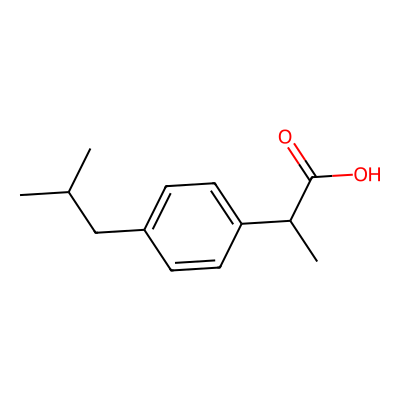

Predicted Solubility
Aqueous Solubility: -3.592 log(mol/L)
Interpretation: Moderately Soluble

Final Recommendation
Strong drug candidate


Pyrethrin II
SMILES: CC1=C(C(=O)C[C@@H]1OC(=O)[C@@H]2[C@H](C2(C)C)/C=C(\C)/C(=O)OC)C/C=C\C=C

Molecular Properties:
  MW: 372.46 Da
  LogP: 3.71
  HBD: 0
  HBA: 5
  Rotatable Bonds: 7
  PSA: 69.67 Ų
  Molar Refractivity: 102.69
  Atoms: 27
  QED Score: 0.387

Lipinski's Rule of 5:
  MW <= 500: Pass
  LogP <= 5: Pass
  HBD <= 5: Pass
  HBA <= 10: Pass
  Overall: Pass

Rule of 3:
  MW <= 300: Fail
  LogP <= 3: Fail
  HBD <= 3: Pass
  HBA <= 3: Fail
  RotBonds <= 3: Fail
  Overall: Fail

Veber Filter:
  RotBonds <= 10: Pass
  PSA <= 140: Pass
  Overall: Pass

Ghose Filter:
  MW: 160 to 480: Pass
  LogP: 0.4 to 5.6: Pass
  MR: 40 to 130: Pass
  Atoms: 20 to 70: Pass
  Overall: Pass

Overall Assessment: Likely orally bioavailable drug candidate

QED Score: 0.387


[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValen

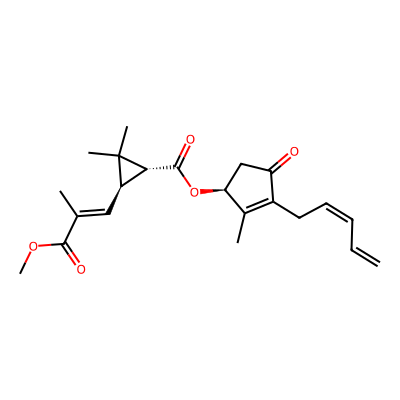

Predicted Solubility
Aqueous Solubility: -5.239 log(mol/L)
Interpretation: Poorly Soluble

Final Recommendation
Solubility concerns


Erythromycin
SMILES: CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(C(O2)C)O)(C)OC)C)OC3C(C(CC(O3)C)N(C)C)O)(C)O)C)C)O)(C)O

Molecular Properties:
  MW: 733.94 Da
  LogP: 1.79
  HBD: 5
  HBA: 14
  Rotatable Bonds: 7
  PSA: 193.91 Ų
  Molar Refractivity: 186.26
  Atoms: 51
  QED Score: 0.238

Lipinski's Rule of 5:
  MW <= 500: Fail
  LogP <= 5: Pass
  HBD <= 5: Pass
  HBA <= 10: Fail
  Overall: Fail

Rule of 3:
  MW <= 300: Fail
  LogP <= 3: Pass
  HBD <= 3: Fail
  HBA <= 3: Fail
  RotBonds <= 3: Fail
  Overall: Fail

Veber Filter:
  RotBonds <= 10: Pass
  PSA <= 140: Fail
  Overall: Fail

Ghose Filter:
  MW: 160 to 480: Fail
  LogP: 0.4 to 5.6: Pass
  MR: 40 to 130: Fail
  Atoms: 20 to 70: Pass
  Overall: Fail

Overall Assessment: Poor drug-likeness, significant optimisation needed

QED Score: 0.238


[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValen

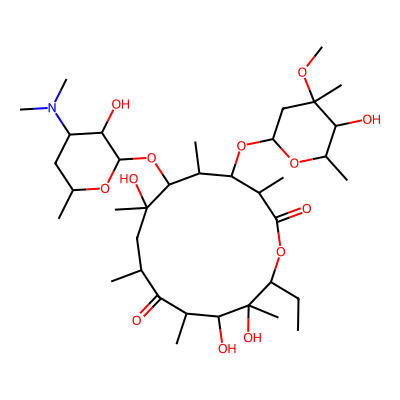

Predicted Solubility
Aqueous Solubility: -2.357 log(mol/L)
Interpretation: Moderately Soluble

Final Recommendation
Poor candidate




[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[01:34:28] DEPRECATION WARNING: please use GetValen

In [134]:
test_molecules = {
    'Ibuprofen': 'CC(C)Cc1ccc(cc1)C(C)C(=O)O',
    'Pyrethrin II': 'CC1=C(C(=O)C[C@@H]1OC(=O)[C@@H]2[C@H](C2(C)C)/C=C(\C)/C(=O)OC)C/C=C\C=C',
    'Erythromycin': 'CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(C(O2)C)O)(C)OC)C)OC3C(C(CC(O3)C)N(C)C)O)(C)O)C)C)O)(C)O'
}

for name, smiles in test_molecules.items():
    check_druglikeness_with_ml(smiles, molecule_name=name);
    print()